---
# IFSAR/LIDAR CHM and SRLITE CHM CNN workflow 2023
author: "Matt Macander"
date: '2023-10-06'
output: html_document
---

Start with center points for 128m (64x64 pixel) chips, in areas of overlapping CHM and VHR imagery

# Versions

v2023-09-16 all valid chips (650k)

v2023-09-19 1% subset, use local terrain as predictor instead of DTM

v2023-09-25 GLIHT and IFSAR CHM, local terrain as predictor instead of DTM

v2023-09-26 GLIHT and IFSAR CHM, DTM as predictor for comparison and because pipeline not set up for rDTM yet

v2023-10-05 GLiHT with IFSAR rDTM as predictor, test with new paths

v2023-10-06 GLiHT 2014/2018 and DGGS Lidar combined, rDTM
v2023-10-06b Add IFSAR
v2023-10-06c Remove rDTM and DTM from predictor stack, prediction pipeline not set up for rDTM yet

v2023-10-14 Fix 8-band exports to 4-band predictor stack (had been exporting as Green/Red/Coastal/RedEdge instead of Blue/Green/Red/NIR)


# Setup
## Run on ADAPT PRISM JupyterHub
Initialize R

In [17]:
library(sf)
library(tidyverse)
library(janitor)
library(magrittr)
library(lubridate)
library(fs)
library(glue)
library(readxl)
library(terra)
library(furrr)
library(exactextractr)
library(DT)

basePath <- path('/explore/nobackup/people/mmacande/srlite/chm_model')
outPath <- path('/explore/nobackup/people/mmacande/srlite/chm_model/20231014_chm')
dir_create(outPath)

## Fix Jupyter / R / GDAL
Code blocks below are dealing with gdal path issue on adapt. Still needed as of 2023-08-31

Run once

In [2]:
secondPath <- sf_proj_search_paths()[[2]]
sf_proj_search_paths(secondPath)

# sf_proj_search_paths('/explore/nobackup/people/mmacande/proj')
# Uncomment line below to see proj search paths
# dir_ls(sf_proj_search_paths())

[1] "/home/mmacande/.conda/envs/r4-base-20230102/share/proj"

# Ingest IFSAR CSV with intersection of regular grid points and footprints
Load point file generated at ABR using SRLite cloud masks eroded (or anti-buffered) by 128 pixel diagonals to ensure all points had full 256x256 chip

On repeat runs can skip to fortified and filtered CSV

Lidar points initial ingest in separate notebook (2023-10-06 folder)

In [3]:
points <- read_sf(path(basePath, 'sample_points', 'ak128m_x_vhr_p05_v20231006.csv')) %>%
    # select(pointid, lidar_fp_path, BUFF_DIST, lat84, lon84, file_vhr = file) %>%
    # mutate(file_lidar = path_file(lidar_fp_path), 
    #        file_lidar = str_replace(file_lidar, '_fp.gpkg', '.tif'),
    #        path_lidar = path_dir(lidar_fp_path)) %>%
    st_as_sf(coords=c('lon84','lat84'), crs=4326, agr="constant", remove=F)
# mutate(epsg = as.integer(epsg))
      # chipName = str_replace(chipName, 'v20230523', 'v20230829'))

colnames(points)
head(points %>% st_drop_geometry())
nrow(points)
# print(points %>% group_by(epsg) %>% tally())
# st_crs(points)

[1] "pointid"  "catid"    "lon84"    "lat84"    "geometry"

pointid,catid,lon84,lat84
<chr>,<chr>,<chr>,<chr>
102041898,104001003D8F4600,-159.6802204590335,55.06905199535327
78831607,1030010025251600,-161.0948106184831,60.269376184969744
83805875,103001005B751600,-161.63438603925252,59.700530289473186
103735746,10300100A6AD3800,-169.8974256025443,52.77022112051301
102266214,104001004DD70D00,-164.26768422354473,54.62422455885007
101758740,10300100A534D100,-164.0259137865075,54.90993923276043


[1] 6668853

## Ancillary layers for spatial joins used to attribute and filter points

In [4]:
ak_yukon_boreal_arctic <- read_sf(path(basePath, 'gis_layers/AKVEG_Regions.gpkg'),
                                  layer='NorthAmericanBeringia_ModelArea_3338')
mrfy <- rast(path(basePath, 'gis_layers', 'mrfy_ak_1940_2022_30m_3338_u16.tif'))

ifsar_metadata <- read_sf(path(basePath, 'gis_layers','ifsar_metadata_x_ifsar_extent_wOcean.shp')) %>%
  rename(ifsar_year = year,
         ifsar_cell = cell) %>%
  mutate(ifsar_year = as.integer(ifsar_year),
         ifsar_year = if_else(is.na(ifsar_year), 0L, ifsar_year)) %>%
  select(ifsar_year, ifsar_cell) %>%
  st_make_valid()


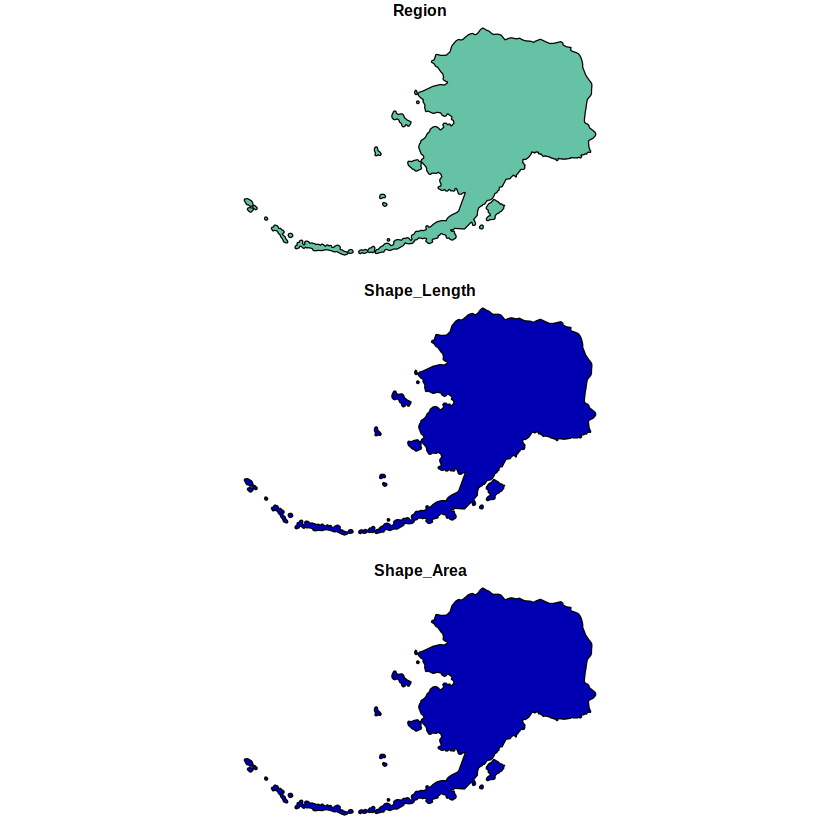

In [5]:
plot(ak_yukon_boreal_arctic)

### Spatial joins

In [ ]:
points_join <- st_join(points, ifsar_metadata, join=st_within)
points_join <- st_join(points_join, ak_yukon_boreal_arctic %>% st_transform(4326), join=st_within)

In [ ]:
mrfy_max = tibble(mrfy_max = exact_extract(mrfy, points %>% st_transform(3338) %>% st_buffer(64), fun='max'))

mrfy_max <- mrfy_max %>%
  mutate(mrfy_max = if_else(is.na(mrfy_max), 1900, mrfy_max))

In [ ]:
class(points_join)

In [ ]:
nrow(points_join)
colnames(points_join)

nrow(mrfy_max)
colnames(mrfy_max)

In [ ]:
points_join %>% st_drop_geometry() %>% group_by(pointid, catid) %>% tally %>% filter(n>1)

points_join %>% st_drop_geometry() %>% filter(pointid == '9920381', catid == '104001002E718B00')

## Clean up a few dups from tiny overlaps in ifsar_cells

In [ ]:
points_join_w_dups <- points_join
points_join <- points_join_w_dups %>%
st_drop_geometry() %>%
group_by(pointid, catid) %>%
slice_head(n=1)

nrow(points_join_w_dups)
nrow(points_join)

In [ ]:
points_join <- bind_cols(points_join, mrfy_max)

In [ ]:
# points_x_ifsar_sa_fire %>% st_drop_geometry() %>% group_by(ifsar_year) %>% tally()
# points_x_ifsar_sa_fire %>% st_drop_geometry() %>% group_by(Region) %>% tally()
# points_x_ifsar_sa_fire %>% st_drop_geometry() %>% group_by(mrfy_max) %>% tally()
colnames(points_join)

## Get Paths of SRLite inputs to join on catid

In [ ]:
#FP file is out of date
srlite_fp <- read_sf('/explore/nobackup/people/pmontesa/srlite/footprints_vhrmeta_SR_alaska.gpkg') %>%
  mutate(srlitePath = path(path, file))
colnames(srlite_fp)

# srlite_fp_fs <- tibble(srlitePath = dir_ls('/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska', recurse=T, glob='*csv*/*-sr-02m.tif')) %>%
srlite_fp_fs <- tibble(srlitePath = dir_ls('/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite', recurse=T, glob='*csv*/*-sr-02m.tif')) %>%

#Get list off file system
#Remove dups with OLS processing
filter(!str_detect(srlitePath, '/ols/')) %>%
mutate(srliteFile = path_file(srlitePath),
       catid = str_sub(srliteFile, 20, 35))
nrow(srlite_fp)
nrow(srlite_fp_fs)

srlite_fp_fs %>% group_by(catid) %>% tally() %>% filter(n>1)
#Remove dups, keeping the last generated path in alphabetical order
srlite_fp_fs <- srlite_fp_fs %>% group_by(catid) %>% arrange(desc(srlitePath)) %>% slice_head(n=1)
nrow(srlite_fp_fs)



## Ingest SRLite metrics

In [ ]:
srlite_metrics <- read_csv('/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/tables/srlite_metrics_alaska_202308291350.csv') %>%
  select(-`...1`)
dups <- srlite_metrics %>%
  dplyr::group_by(model, file, type, footprint_name, catid, sensor, year, month, date, band_name) %>%
  dplyr::summarise(n = dplyr::n(), .groups = "drop") %>%
  dplyr::filter(n > 1L) 


srlite_metrics_wide <- srlite_metrics %>%
  filter(band_name %in% c('Blue','Green','Red','NIR')) %>%
  pivot_wider(id_cols=c(model, file, type, footprint_name, catid, sensor, year, month, date), names_from=band_name, values_from=intercept:rmse_norm, values_fn=mean) #%>%

colnames(srlite_metrics_wide)
nrow(srlite_metrics_wide)

## Calculate attributes and join SRLite info
## Generate names for image chips

In [ ]:
colnames(points_join)
# points_join %>% st_drop_geometry() %>% head()
points_join %>% head()

In [ ]:
write_csv(points_join, path(basePath, 'sample_points', 'ak128m_x_vhr_p05_v20231006_working.csv'))

In [ ]:
points_join <- points_join %>%
mutate(chmPath = '/explore/nobackup/projects/dem/AK_IFSAR/alaska_ifsar_chm_m_20221222_cog.tif',
       chmName = 'AK_IFSAR_CHM') %>%
rename(chmYear = ifsar_year) %>%
left_join(srlite_fp_fs %>% select(catid, srlitePath)) %>%
relocate(srlitePath, .after=catid)

nrow(points_join)

In [ ]:
colnames(points_join)
points_join %>% head()

In [ ]:
points_fortified <- points_join %>%
  # st_drop_geometry() %>%
  # rename(file_vhr = file) %>%
  select(-starts_with('Shape_')) %>%
  # left_join(ref_lidarYear) %>%
  mutate(#chmYear = as.integer(chmYear),
         #lidarPath = path(path_lidar, file_lidar),
         baseName = str_sub(path_file(srlitePath), 0, 35),
         # baseNameLidar = path_ext_remove(file_lidar),
         vhr_year = as.integer(str_sub(baseName, 6, 9)),
         vhr_mm = as.integer(str_sub(baseName, 10, 11)),
         vhr_dd = as.integer(str_sub(baseName, 12, 13)),
         sensor = str_sub(baseName, 1, 4),
         # catid = str_sub(baseName, 20, 35),
         .before=srlitePath) %>%
  group_by(baseName, chmName) %>%
  # mutate(chip_gran_id = row_number(FID_fishnet_512m_label),
  mutate(chip_gran_id = row_number(pointid),
         chipName = glue('chip_{baseName}_CHM_{chmName}_{str_pad(chip_gran_id, 5, "left", "0")}_v20231006'),
         .before=srlitePath) %>%
  mutate(imageYear_minus_chmYear = vhr_year - chmYear,
         fireYear_minus_imageYear = mrfy_max - vhr_year,
         fireYear_minus_chmYear = mrfy_max - chmYear) %>%
         # fireYear_minus_lidarYear = mrfy_max - lidarYear,
         # imageYear_minus_lidarYear = vhr_year - lidarYear) %>%
         # fireFlag = between(fireYear_minus_imageYear, -1, 0) | between(fireYear_minus_ifsarYear, -1, 0) | between(mrfy_max, pmin(vhr_year, ifsar_year), pmax(vhr_year, ifsar_year))) %>%
  relocate(starts_with('ifsar'), .before=srlitePath) %>%
  relocate(starts_with('fire'), .before=srlitePath) %>%
  relocate(starts_with('mrfy'), .before=srlitePath) %>%
  ungroup() %>%
  left_join(srlite_fp_fs %>% select(catid, srlitePath)) %>%
  left_join(srlite_metrics_wide %>% select(catid, r2_score_NIR)) %>%
  mutate(random = runif(n()), .before=chipName,
         trainTest = case_when(
            random < 0.95 ~ 'train',
            T ~ 'test'))


In [ ]:
# points_fortified = read_csv(path(outPath,'fortified_ak128m_x_vhr_x_ifsar_v20231006.csv'), guess_max=999999)
# points_fortified = points_fortified %>%
# mutate(chmName = 'AK_IFSAR_CHM',
#       chipName = str_replace(chipName, 'Alaska IFSAR CHM', 'AK_IFSAR_CHM'))

In [ ]:
colnames(points_fortified)
points_fortified %>% group_by(vhr_mm) %>% tally()
points_fortified %>% group_by(imageYear_minus_chmYear) %>% tally()
points_fortified %>% group_by(fireYear_minus_chmYear) %>% tally()
# points_fortified %>% group_by(mrfy_max) %>% tally()
# points_fortified %>% group_by(group) %>% tally()

write_csv(points_fortified, path(outPath,'fortified_ak128m_x_vhr_x_ifsar_v20231006.csv'))

In [ ]:
points_fortified %>% group_by(Region) %>% tally()


| fireYear | imageYear | Use Data?
|---|---|---|
|2000|1999|Yes|
|2000|2000|No|
|2000|2001|Yes|

## Filter points (July, August, no recent fires) and save CSV

In [ ]:
filtered_points_land <- points_fortified %>%
filter(vhr_mm %in% c(7,8),   #Retain July/August only
       Region == 'North American Beringia', #Arctic and Boreal Alaska
       r2_score_NIR >= 0.75, #High quality SRLite fit
       mrfy_max != chmYear,#Did not burn same year as lidar collect
       mrfy_max != vhr_year, #Did not burn same year as VHR collect
       !(mrfy_max > chmYear & mrfy_max < vhr_year), #Did not burn after Lidar but before VHR
       !(mrfy_max < chmYear & mrfy_max > vhr_year), #Did not burn after VHR but before Lidar
       between(imageYear_minus_chmYear, -7, 7)) %>% #Imagery and Lidar collected within 7 years of each other
       # between(imageYear_minus_lidarYear, -3, 3)) %>% #Imagery and Lidar collected within 3 years of each other
mutate(group = glue('ifsar_78_{trainTest}_v20231006'))

nrow(filtered_points_land)
nrow(filtered_points_land)
colnames(filtered_points_land)

filtered_points_land %>% group_by(chmYear) %>% tally()

write_csv(filtered_points_land, path(outPath,'fortified_filtered_land_ak128m_x_vhr_x_ifsar_v20231006.csv'))

In [ ]:
filtered_points_ocean <- points_fortified %>%
filter(vhr_mm %in% c(7,8),   #Retain July/August only
       Region == 'North American Beringia', #Arctic and Boreal Alaska
       r2_score_NIR >= 0.75, #High quality SRLite fit
       chmYear == 0) %>%
mutate(group = glue('ifsar_78_ocean_{trainTest}_v20231006'))

nrow(filtered_points_ocean)

In [ ]:
filtered_points <- bind_rows(filtered_points_land, filtered_points_ocean)
write_csv(filtered_points, path(outPath,'fortified_filtered_ak128m_x_vhr_x_ifsar_v20231006.csv'))

nrow(filtered_points)

# IFSAR Chip generation using saved, fortified CSV

In [6]:
filtered_points <- read_csv(path(outPath,'fortified_filtered_ak128m_x_vhr_x_ifsar_v20231006.csv'), guess_max=999999)
nrow(filtered_points)

Rows: 1346046 Columns: 25
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (11): catid, baseName, sensor, trainTest, chipName, ifsar_cell, srlitePa...
dbl (14): pointid, vhr_year, vhr_mm, vhr_dd, chip_gran_id, random, fireYear_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 1346046

In [7]:
#Check for missing srlite path
filtered_points %>% group_by(catid, srlitePath) %>% filter(is.na(srlitePath)) %>% tally()

catid,srlitePath,n
<chr>,<chr>,<int>


In [8]:
filtered_points <- filtered_points %>%
filter(!is.na(srlitePath))
nrow(filtered_points)

[1] 1346046

In [9]:
filtered_points %>%
group_by(chmName) %>%
tally()

chmName,n
<chr>,<int>
AK_IFSAR_CHM,1346046


In [10]:
datatable(
    filtered_points %>%
    group_by(baseName, srlitePath) %>%
    tally() %>% arrange(baseName))

HTML widgets cannot be represented in plain text (need html)

Filtered points to include only July/August, high NIR R2 score, and exclude fire disturbance in ifsar year and greater than 7 year diff between VHR and IFSAR

Function to Load SRLite, IFSAR DSM/DTM/CHM and crop by bounding box.

Save out to image and label geotiffs.

Save index gpkg of chips

In [11]:
# filtered_points %>% st_drop_geometry() %>% head()
# srlitePath = '/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska/batch_1/8_band_csv/split_8/WV02_20130820_M1BS_10300100260A9600-sr-02m.tif'
# sr_2m_strip <- rast(srlitePath)
# crs(sr_2m_strip, describe=T)$code

## Function to generate train/val chips

In [12]:
crop_by_point_chm <- function(geometry, baseName, chipName, outPrefix, srlitePath, chmPath, group) {
    sr_2m_strip <- rast(srlitePath)
    epsg <- as.integer(crs(sr_2m_strip, describe=T)$code)
    
    point <- st_sfc(geometry, crs=4326)
    utmPoint = st_transform(point, epsg)
 
    utmBuff = st_buffer(utmPoint, 64)
    # utmBuff = st_buffer(utmPoint, 256)
    utmBB = st_as_sfc(st_bbox(utmBuff))
    BB3338 = st_transform(utmBB, 3338)
    # sr_2m_strip <- rast(path(alaska_2m, glue('{baseName}-sr-02m.tif')))

    
    # if (nlyr(sr_2m_strip) == 8) { sr_2m_strip <- subset(sr_2m_strip, c(2,3,5,7)) }
    if (nlyr(sr_2m_strip) == 8) { sr_2m_strip <- subset(sr_2m_strip, c(1,2,3,4)) }
    sr_2m <- crop(sr_2m_strip, utmBB)#, filename=path(outPath, glue('{epsg}_{long}_{lat}.tif')))
    
    names(sr_2m) <- c('01_blue','02_green','03_red','04_nir')
    ifsar_dtm_2m <- project(ifsar_dtm, sr_2m, method='bilinear')
    ifsar_dsm_2m <- project(ifsar_dsm, sr_2m, method='bilinear')
    ifsar_dtm_min <- global(ifsar_dtm_2m, 'min')[[1]]
    local_dem_2m <- ifsar_dtm_2m - ifsar_dtm_min
    names(ifsar_dtm_2m) <- c('05_ifsar_dtm_m')
    names(local_dem_2m) <- c('05_local_dem_m')
    predictor_stack_2m <- c(sr_2m, local_dem_2m)
    # predictor_stack_2m <- c(sr_2m, ifsar_dtm_2m)

    ifsar_chm_2m <- ifsar_dsm_2m - ifsar_dtm_2m
    ifsar_chm_2m <- clamp(ifsar_chm_2m, 0, 100)
    names(ifsar_chm_2m) <- c('06_ifsar_chm_m')

    # lidar_chm_2m <- project(rast(chmPath), sr_2m, method='average')
    # lidar_chm_2m <- clamp(lidar_chm_2m, 0, 100)
    # names(lidar_chm_2m) <- c('06_lidar_chm_m')
    
    #TODO optimize to run once and get all stats
    predictor_isNA <- sum(global(predictor_stack_2m, 'isNA')[[1]])
    ifsar_chm_isNA = global(ifsar_chm_2m, 'isNA')[[1]]
    ifsar_chm_percentiles = global(ifsar_chm_2m, fun=quantile, probs=c(0.00,0.50,0.90,0.98,1.00))
    ifsar_chm_min = ifsar_chm_percentiles[[1]]
    ifsar_chm_p50 = ifsar_chm_percentiles[[2]]
    ifsar_chm_p90 = ifsar_chm_percentiles[[3]]
    ifsar_chm_p98 = ifsar_chm_percentiles[[4]]
    ifsar_chm_max = ifsar_chm_percentiles[[5]]
    ifsar_chm_range = ifsar_chm_max - ifsar_chm_min
    
    # lidar_chm_isNA = global(lidar_chm_2m, 'isNA')[[1]]
    # lidar_chm_percentiles = global(lidar_chm_2m, fun=quantile, probs=c(0.00,0.50,0.90,0.98,1.00))
    # lidar_chm_min = lidar_chm_percentiles[[1]]
    # lidar_chm_p50 = lidar_chm_percentiles[[2]]
    # lidar_chm_p90 = lidar_chm_percentiles[[3]]
    # lidar_chm_p98 = lidar_chm_percentiles[[4]]
    # lidar_chm_max = lidar_chm_percentiles[[5]]
    # lidar_chm_range = lidar_chm_max - lidar_chm_min
    
    # print(glue('{chm_min}, {chm_p50}, {chm_p90}, {chm_p98}, {chm_max}, {chm_range}'))
    if(ifsar_chm_isNA > 0) {
        # print(glue('{chipName} includes {chm_isNA} nodata pixels in CHM, not exported')) 
        chipStatus = glue('Chip dropped, nodata in CHM')
        # } else if (lidar_chm_isNA > 0) {
        # chipStatus = glue('Chip dropped, nodata in lidar CHM')
        } else if (predictor_isNA > 0) {
        chipStatus = glue('Chip dropped, nodata in predictor stack')
        # } else if (chm_range <= 0.01) {   
        # print(glue('{chipName} is a constant or near constant chm of {chm_min}, not exported')) 
        # chipStatus = glue('Chip dropped, CHM constant or near constant at {chm_min}')
        } else {
        # print(glue('Exporting {chipName}'))
        writeRaster(predictor_stack_2m, filename=path(outPath, glue('{outPrefix}_ifsar_images'), glue('{chipName}.tif')), overwrite=T)
        writeRaster(ifsar_chm_2m, filename=path(outPath, glue('{outPrefix}_ifsar_chm'), glue('{chipName}.tif')), overwrite=T)
        # writeRaster(lidar_chm_2m, filename=path(outPath, glue('{outPrefix}_lidar_chm'), glue('{chipName}.tif')), overwrite=T)
        chipStatus = 'Chip exported'
    }

    return(tibble(BB3338, baseName, chipName, outPrefix, srlitePath, chmPath, group, chipStatus, 
                  ifsar_chm_min, ifsar_chm_p50, ifsar_chm_p90, ifsar_chm_p98, ifsar_chm_max, 
                  # lidar_chm_min, lidar_chm_p50, lidar_chm_p90, lidar_chm_p98, lidar_chm_max,
                  predictor_isNA, ifsar_chm_isNA))#, lidar_chm_isNA))
}

## Optional to look at chips that failed to export
Needs to be fixed

In [14]:
#BB Only for chips that errored
bb_by_point <- function(geometry, baseName, chipName, outPrefix, srlitePath, lidarPath, group) {
    # print(epsg)
    # print(geometry)
    point <- st_sfc(geometry, crs=4326)
    # print(point)
    utmPoint = st_transform(point, epsg)
    # print(utmPoint)
    utmBuff = st_buffer(utmPoint, 64)
    utmBB = st_as_sfc(st_bbox(utmBuff))
    BB3338 = st_transform(utmBB, 3338)

    chipStatus = 'Error during chip processing, not exported'

    return(tibble(epsg, BB3338, baseName, chipName, outPrefix, srlitePath, lidarPath, chm_mean_cm, group, chipStatus))
}

## Setup DEM sources and output folders

In [19]:
ifsar_dtm <- rast('/explore/nobackup/projects/dem/AK_IFSAR/alaska_ifsar_dtm_20221222.tif')
ifsar_dsm <- rast('/explore/nobackup/projects/dem/AK_IFSAR/alaska_ifsar_dsm_20221222.tif')

# dir_create(path(outPath, 'train_ifsar_images'))
dir_create(path(outPath, 'train_ifsar_nodtm_images'))
dir_create(path(outPath, 'train_ifsar_chm'))

# dir_create(path(outPath, 'test_ifsar_images'))
dir_create(path(outPath, 'test_ifsar_nodtm_images'))
dir_create(path(outPath, 'test_ifsar_chm'))


## Create geometries from lat/lon table

In [20]:
filtered_points_gis <- filtered_points %>%
st_as_sf(coords=c('lon84','lat84'), crs=4326, agr="constant", remove=F)


# IFSAR Chip Workflow with rDTM (skip)

## Small scale testing trials

In [25]:
test2 <- F
if(test2) {
# filtered_points_train %>% select(epsg, geometry, baseName, chipName, srlitePath, chm_mean_cm) %>% 
filtered_points_gis %>% select(geometry, baseName, chipName, srlitePath, chmPath, group, outPrefix = trainTest) %>% 
# mutate(group = 'subset trial', outPrefix = 'train') %>% 
st_drop_geometry() %>% 
ungroup() %>% 
slice_sample(n=2)
}

In [26]:
if(test2) {
pwalk(filtered_points_gis %>% select(geometry, baseName, chipName, srlitePath, chmPath, group, outPrefix = trainTest) %>% 
      # mutate(group = 'subset trial', outPrefix = 'train') %>% 
      # st_drop_geometry() %>% 
      ungroup() %>% 
      slice_sample(n=2),
      crop_by_point_chm)
}

In [ ]:
if(test2) {
result <- pmap_dfr(filtered_points_gis %>% select(geometry, baseName, chipName, srlitePath, chmPath, group, outPrefix = trainTest) %>% 
      # st_drop_geometry() %>% 
      ungroup() %>% 
      slice_sample(n=2),
      crop_by_point_chm)
result
}


## Set up parallel environment

In [ ]:
plan(multicore, workers=36)

In [ ]:
#To kill furrr processes if needed
# v <- listenv::listenv()  # requires listenv package
# for (ii in 1:36) {
#    v[[ii]] %<-% {
#          Sys.getpid()
#      }
# }
# for (i in 1:36) {
#   #For Linux
#   system(sprintf("kill -9 %s", v[[i]]))
# }


In [ ]:
plan()

In [ ]:
#Don't think random number generation within parallel is an issue here so quiet the warnings. See below
#https://www.r-bloggers.com/2020/09/future-1-19-1-making-sure-proper-random-numbers-are-produced-in-parallel-processing/
options(future.rng.onMisuse = "ignore")
# options()

In [ ]:
nrow(filtered_points_gis)

## Batch testing trial (run rm -fr test_* train_* afterwards and run fresh export with testSubset = F)

In [ ]:
filtered_points_gis_subset <- filtered_points_gis %>%
slice_sample(prop=0.2)

In [ ]:
nrow(filtered_points_gis_subset)

In [ ]:
testSubset = F
if(testSubset) {
    nrow(filtered_points_gis)
    filtered_points_gis <- filtered_points_gis %>%
    slice_sample(n = 1000)
    nrow(filtered_points_gis)
}


## Run full batch parallel chip generation

In [ ]:
chips_df <- future_pmap_dfr(filtered_points_gis_subset %>% select(geometry, baseName, chipName, srlitePath, chmPath, group, outPrefix = trainTest) %>% 
                            ungroup(), 
                            possibly(crop_by_point_chm, otherwise=NULL))

In [ ]:
nrow(chips_df)
colnames(chips_df)
chips_df %>% group_by(chipStatus) %>% tally()

## Save gpkg of chips with metadata including CHM stats

In [ ]:
write_sf(chips_df %>% rename(groupName = group), path(outPath, 'chips_df_ifsar_chm_v20231006.gpkg'))

## Mismatched train images and labels, clean up

In [ ]:
train_image <- tibble(trainImagePath = dir_ls(path(outPath, 'train_ifsar_images'), glob='*.tif')) %>%
                     mutate(trainFile = path_file(trainImagePath))
train_label <- tibble(trainLabelPath = dir_ls(path(outPath, 'train_ifsar_chm'), glob='*.tif')) %>%
                     mutate(trainFile = path_file(trainLabelPath))

extra_image <- train_image %>%
anti_join(train_label)
extra_image

extra_label <- train_label %>%
anti_join(train_image)
extra_label


In [ ]:
file_delete(extra_image$trainImagePath)
file_delete(extra_label$trainLabelPath)


## Generate bounding box for chips that did not process due to error
Needs to be fixed

In [ ]:
chips_df_dropped <- filtered_points_gis %>% anti_join(chips_df, by='chipName')
nrow(filtered_points_gis)
nrow(chips_df)
nrow(chips_df_dropped)

In [ ]:
chips_df_dropped_wBB <- future_pmap_dfr(chips_df_dropped %>% 
                               select(geometry, baseName, chipName, srlitePath, lidarPath, group, outPrefix = trainTest) %>% 
                               ungroup(), 
      possibly(bb_by_point))#, otherwise=NULL))
nrow(chips_df_dropped_wBB)

In [ ]:
if(nrow(chips_df_dropped_wBB) > 0) {
    chips_df_full <- bind_rows(
        chips_df,
        chips_df_dropped_wBB) 
    } else { chips_df_full <- chips_df }

nrow(chips_df_full)

In [ ]:
# file_delete('/explore/nobackup/people/mmacande/srlite/chm_model/20230829_chm/chips_df_v20230829_full.gpkg')
# write_sf(chips_df_full, path(outPath, 'chips_df_v20231005_full.gpkg'))

# IFSAR Chip Workflow without DTM or rDTM in predictor

In [29]:
crop_by_point_chm_nodtm <- function(geometry, baseName, chipName, outPrefix, srlitePath, chmPath, group) {
    sr_2m_strip <- rast(srlitePath)
    epsg <- as.integer(crs(sr_2m_strip, describe=T)$code)
    
    point <- st_sfc(geometry, crs=4326)
    utmPoint = st_transform(point, epsg)
 
    utmBuff = st_buffer(utmPoint, 64)
    # utmBuff = st_buffer(utmPoint, 256)
    utmBB = st_as_sfc(st_bbox(utmBuff))
    BB3338 = st_transform(utmBB, 3338)
    # sr_2m_strip <- rast(path(alaska_2m, glue('{baseName}-sr-02m.tif')))

    
    if (nlyr(sr_2m_strip) == 8) { sr_2m_strip <- subset(sr_2m_strip, c(1,2,3,4)) }
    # if (nlyr(sr_2m_strip) == 8) { sr_2m_strip <- subset(sr_2m_strip, c(2,3,5,7)) }
    sr_2m <- crop(sr_2m_strip, utmBB)#, filename=path(outPath, glue('{epsg}_{long}_{lat}.tif')))
    
    names(sr_2m) <- c('01_blue','02_green','03_red','04_nir')
    ifsar_dtm_2m <- project(ifsar_dtm, sr_2m, method='bilinear')
    ifsar_dsm_2m <- project(ifsar_dsm, sr_2m, method='bilinear')
    ifsar_dtm_min <- global(ifsar_dtm_2m, 'min')[[1]]
    local_dem_2m <- ifsar_dtm_2m - ifsar_dtm_min
    names(ifsar_dtm_2m) <- c('05_ifsar_dtm_m')
    names(local_dem_2m) <- c('05_local_dem_m')
    predictor_stack_2m <- c(sr_2m)
    # predictor_stack_2m <- c(sr_2m, local_dem_2m)
    # predictor_stack_2m <- c(sr_2m, ifsar_dtm_2m)

    ifsar_chm_2m <- ifsar_dsm_2m - ifsar_dtm_2m
    ifsar_chm_2m <- clamp(ifsar_chm_2m, 0, 100)
    names(ifsar_chm_2m) <- c('06_ifsar_chm_m')

    # lidar_chm_2m <- project(rast(chmPath), sr_2m, method='average')
    # lidar_chm_2m <- clamp(lidar_chm_2m, 0, 100)
    # names(lidar_chm_2m) <- c('06_lidar_chm_m')
    
    #TODO optimize to run once and get all stats
    predictor_isNA <- sum(global(predictor_stack_2m, 'isNA')[[1]])
    ifsar_chm_isNA = global(ifsar_chm_2m, 'isNA')[[1]]
    # ifsar_chm_percentiles = global(ifsar_chm_2m, fun=quantile, probs=c(0.00,0.50,0.90,0.98,1.00))
    # ifsar_chm_min = ifsar_chm_percentiles[[1]]
    # ifsar_chm_p50 = ifsar_chm_percentiles[[2]]
    # ifsar_chm_p90 = ifsar_chm_percentiles[[3]]
    # ifsar_chm_p98 = ifsar_chm_percentiles[[4]]
    # ifsar_chm_max = ifsar_chm_percentiles[[5]]
    # ifsar_chm_range = ifsar_chm_max - ifsar_chm_min
    
    # lidar_chm_isNA = global(lidar_chm_2m, 'isNA')[[1]]
    # lidar_chm_percentiles = global(lidar_chm_2m, fun=quantile, probs=c(0.00,0.50,0.90,0.98,1.00))
    # lidar_chm_min = lidar_chm_percentiles[[1]]
    # lidar_chm_p50 = lidar_chm_percentiles[[2]]
    # lidar_chm_p90 = lidar_chm_percentiles[[3]]
    # lidar_chm_p98 = lidar_chm_percentiles[[4]]
    # lidar_chm_max = lidar_chm_percentiles[[5]]
    # lidar_chm_range = lidar_chm_max - lidar_chm_min
    
    # print(glue('{chm_min}, {chm_p50}, {chm_p90}, {chm_p98}, {chm_max}, {chm_range}'))
    if(ifsar_chm_isNA > 0) {
        # print(glue('{chipName} includes {chm_isNA} nodata pixels in CHM, not exported')) 
        chipStatus = glue('Chip dropped, nodata in CHM')
        # } else if (lidar_chm_isNA > 0) {
        # chipStatus = glue('Chip dropped, nodata in lidar CHM')
        } else if (predictor_isNA > 0) {
        chipStatus = glue('Chip dropped, nodata in predictor stack')
        # } else if (chm_range <= 0.01) {   
        # print(glue('{chipName} is a constant or near constant chm of {chm_min}, not exported')) 
        # chipStatus = glue('Chip dropped, CHM constant or near constant at {chm_min}')
        } else {
        # print(glue('Exporting {chipName}'))
        writeRaster(predictor_stack_2m, filename=path(outPath, glue('{outPrefix}_ifsar_nodtm_images'), glue('{chipName}.tif')), overwrite=T)
        writeRaster(ifsar_chm_2m, filename=path(outPath, glue('{outPrefix}_ifsar_chm'), glue('{chipName}.tif')), overwrite=T)
        # writeRaster(lidar_chm_2m, filename=path(outPath, glue('{outPrefix}_lidar_chm'), glue('{chipName}.tif')), overwrite=T)
        chipStatus = 'Chip exported'
    }

    return(tibble(BB3338, baseName, chipName, outPrefix, srlitePath, chmPath, group, chipStatus, 
                  # ifsar_chm_min, ifsar_chm_p50, ifsar_chm_p90, ifsar_chm_p98, ifsar_chm_max, 
                  # lidar_chm_min, lidar_chm_p50, lidar_chm_p90, lidar_chm_p98, lidar_chm_max,
                  predictor_isNA, ifsar_chm_isNA))#, lidar_chm_isNA))
}

## Small scale testing trials

In [30]:
test2 <- T
if(test2) {
# filtered_points_train %>% select(epsg, geometry, baseName, chipName, srlitePath, chm_mean_cm) %>% 
filtered_points_gis %>% select(geometry, baseName, chipName, srlitePath, chmPath, group, outPrefix = trainTest) %>% 
# mutate(group = 'subset trial', outPrefix = 'train') %>% 
st_drop_geometry() %>% 
ungroup() %>% 
slice_sample(n=2)
}

baseName,chipName,srlitePath,chmPath,group,outPrefix
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
WV02_20180706_M1BS_1030010081668400,chip_WV02_20180706_M1BS_1030010081668400_CHM_AK_IFSAR_CHM_00222_v20231006,/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite/alaska_batch_1/8_band_csv/split_7_1/WV02_20180706_M1BS_1030010081668400-sr-02m.tif,/explore/nobackup/projects/dem/AK_IFSAR/alaska_ifsar_chm_m_20221222_cog.tif,ifsar_78_train_v20231006,train
WV02_20150815_M1BS_103001004769F300,chip_WV02_20150815_M1BS_103001004769F300_CHM_AK_IFSAR_CHM_02757_v20231006,/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite/alaska_batch_1/8_band_csv/split_4/WV02_20150815_M1BS_103001004769F300-sr-02m.tif,/explore/nobackup/projects/dem/AK_IFSAR/alaska_ifsar_chm_m_20221222_cog.tif,ifsar_78_train_v20231006,train


In [33]:
if(test2) {
pwalk(filtered_points_gis %>% select(geometry, baseName, chipName, srlitePath, chmPath, group, outPrefix = trainTest) %>% 
      # mutate(group = 'subset trial', outPrefix = 'train') %>% 
      # st_drop_geometry() %>% 
      ungroup() %>% 
      slice_sample(n=2),
      crop_by_point_chm_nodtm)
}

In [34]:
if(test2) {
result <- pmap_dfr(filtered_points_gis %>% select(geometry, baseName, chipName, srlitePath, chmPath, group, outPrefix = trainTest) %>% 
      # st_drop_geometry() %>% 
      ungroup() %>% 
      slice_sample(n=2),
      crop_by_point_chm_nodtm)
result
}


BB3338,baseName,chipName,outPrefix,srlitePath,chmPath,group,chipStatus,predictor_isNA,ifsar_chm_isNA
<POLYGON [m]>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
POLYGON ((-227941.4 1220834...,WV02_20160829_M1BS_10300100594E5700,chip_WV02_20160829_M1BS_10300100594E5700_CHM_AK_IFSAR_CHM_00711_v20231006,train,/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite/alaska_batch_1/8_band_csv/split_7_0/WV02_20160829_M1BS_10300100594E5700-sr-02m.tif,/explore/nobackup/projects/dem/AK_IFSAR/alaska_ifsar_chm_m_20221222_cog.tif,ifsar_78_train_v20231006,Chip exported,0,0
"POLYGON ((558892.2 1997778,...",WV03_20150706_M1BS_104001000EBE4300,chip_WV03_20150706_M1BS_104001000EBE4300_CHM_AK_IFSAR_CHM_00771_v20231006,train,/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite/alaska_batch_1/8_band_csv/split_4/WV03_20150706_M1BS_104001000EBE4300-sr-02m.tif,/explore/nobackup/projects/dem/AK_IFSAR/alaska_ifsar_chm_m_20221222_cog.tif,ifsar_78_ocean_train_v20231006,Chip exported,0,0


## Set up parallel environment

In [35]:
plan(multicore, workers=36)

In [36]:
#To kill furrr processes if needed
# v <- listenv::listenv()  # requires listenv package
# for (ii in 1:36) {
#    v[[ii]] %<-% {
#          Sys.getpid()
#      }
# }
# for (i in 1:36) {
#   #For Linux
#   system(sprintf("kill -9 %s", v[[i]]))
# }


In [37]:
plan()

multicore:
- args: function (..., workers = 36, envir = parent.frame())
- tweaked: TRUE
- call: plan(multicore, workers = 36)

In [38]:
#Don't think random number generation within parallel is an issue here so quiet the warnings. See below
#https://www.r-bloggers.com/2020/09/future-1-19-1-making-sure-proper-random-numbers-are-produced-in-parallel-processing/
options(future.rng.onMisuse = "ignore")
# options()

In [39]:
nrow(filtered_points_gis)

[1] 1346046

## Batch testing trial (run rm -fr test_* train_* afterwards and run fresh export with testSubset = F)

In [41]:
subset_w_dtm <- read_sf(path(basePath, '20231006_chm','chips_df_ifsar_chm_v20231006.gpkg')) %>%
st_drop_geometry() %>%
select(chipName)

In [42]:
filtered_points_gis_subset <- filtered_points_gis %>%
semi_join(subset_w_dtm)

Joining, by = "chipName"


In [43]:
nrow(filtered_points_gis_subset)

[1] 269003

In [44]:
testSubset = F
if(testSubset) {
    nrow(filtered_points_gis)
    filtered_points_gis <- filtered_points_gis %>%
    slice_sample(n = 1000)
    nrow(filtered_points_gis)
}


## Run full batch parallel chip generation

In [45]:
chips_df <- future_pmap_dfr(filtered_points_gis_subset %>% select(geometry, baseName, chipName, srlitePath, chmPath, group, outPrefix = trainTest) %>% 
                            ungroup(), 
                            possibly(crop_by_point_chm_nodtm, otherwise=NULL))

Warning message in x@ptr$writeRaster(opt):
“GDAL Error 4: Attempt to create new tiff file `/explore/nobackup/people/mmacande/srlite/chm_model/20231014_chm/train_ifsar_nodtm_images/chip_WV02_20150822_M1BS_1030010049338D00_CHM_AK_IFSAR_CHM_02192_v20231006.tif' failed: Permission denied”


In [47]:
nrow(chips_df)
colnames(chips_df)
chips_df %>% group_by(chipStatus) %>% tally()

[1] 269002

[1] "BB3338"         "baseName"       "chipName"       "outPrefix"     
 [5] "srlitePath"     "chmPath"        "group"          "chipStatus"    
 [9] "predictor_isNA" "ifsar_chm_isNA"

chipStatus,n
<glue>,<int>
"Chip dropped, nodata in predictor stack",338
Chip exported,268664


## Save gpkg of chips with metadata including CHM stats

In [48]:
write_sf(chips_df %>% rename(groupName = group), path(outPath, 'chips_df_ifsar_chm_nodtm_v20231014.gpkg'))

## Mismatched train images and labels, clean up

In [ ]:
train_image <- tibble(trainImagePath = dir_ls(path(outPath, 'train_ifsar_nodtm_images'), glob='*.tif')) %>%
                     mutate(trainFile = path_file(trainImagePath))
train_label <- tibble(trainLabelPath = dir_ls(path(outPath, 'train_ifsar_chm'), glob='*.tif')) %>%
                     mutate(trainFile = path_file(trainLabelPath))

extra_image <- train_image %>%
anti_join(train_label)
extra_image

extra_label <- train_label %>%
anti_join(train_image)
extra_label


In [ ]:
file_delete(extra_image$trainImagePath)
file_delete(extra_label$trainLabelPath)


## Generate List of strips that were used in training / test chips

In [82]:
colnames(filtered_points)
train_strips <- filtered_points %>%
group_by(srlitePath) %>% tally()
datatable(train_strips)
# write_csv(train_strips %>% select(srlitePath), path(outPath, 'training_strips_ifsar_20231006.csv'))

write_csv(train_strips %>% select(srlitePath), path(outPath, 'training_strips_ifsar_20231014.csv'))

[1] "pointid"                  "catid"                   
 [3] "baseName"                 "vhr_year"                
 [5] "vhr_mm"                   "vhr_dd"                  
 [7] "sensor"                   "chip_gran_id"            
 [9] "random"                   "trainTest"               
[11] "chipName"                 "ifsar_cell"              
[13] "fireYear_minus_imageYear" "fireYear_minus_chmYear"  
[15] "mrfy_max"                 "srlitePath"              
[17] "lon84"                    "lat84"                   
[19] "chmYear"                  "Region"                  
[21] "chmPath"                  "chmName"                 
[23] "imageYear_minus_chmYear"  "r2_score_NIR"            
[25] "group"

HTML widgets cannot be represented in plain text (need html)

# Lidar Chips Workflow
Initial CSV ingest in separate notebook (2023-10-06)

In [51]:
filtered_points_lidar <- read_csv(path(basePath, '20231006_chm','fortified_filtered_ak128m_x_vhr_x_lidar_v20231005.csv'))
nrow(filtered_points_lidar)
colnames(filtered_points_lidar)

Rows: 450595 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (11): baseName, sensor, catid, trainTest, chipName, file_vhr, chmPath, c...
dbl (16): pointid, vhr_year, vhr_mm, vhr_dd, chip_gran_id, random, ifsar_yea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 450595

[1] "pointid"                  "baseName"                
 [3] "vhr_year"                 "vhr_mm"                  
 [5] "vhr_dd"                   "sensor"                  
 [7] "catid"                    "chip_gran_id"            
 [9] "random"                   "trainTest"               
[11] "chipName"                 "ifsar_year"              
[13] "ifsar_cell"               "fireYear_minus_imageYear"
[15] "fireYear_minus_chmYear"   "mrfy_max"                
[17] "file_vhr"                 "chmPath"                 
[19] "chmYear"                  "chmName"                 
[21] "lat84"                    "lon84"                   
[23] "Region"                   "imageYear_minus_chmYear" 
[25] "srlitePath"               "r2_score_NIR"            
[27] "group"

In [52]:
#Check for missing srlite path
filtered_points_lidar %>% group_by(catid, srlitePath, file_vhr) %>% filter(is.na(srlitePath)) %>% tally()

catid,srlitePath,file_vhr,n
<chr>,<chr>,<chr>,<int>
10300100972EDD00,NA,WV02_20190817_M1BS_10300100972EDD00-toa.cloudmask.tif,1753
104001004FC15B00,NA,WV03_20190830_M1BS_104001004FC15B00-toa.cloudmask.tif,430


In [53]:
filtered_points_lidar <- filtered_points_lidar %>%
filter(!is.na(srlitePath))
nrow(filtered_points_lidar)

[1] 448412

In [54]:
filtered_points_lidar %>%
group_by(chmName) %>%
tally()

chmName,n
<chr>,<int>
fairbanks_ql1_2017,25156
fairbanks_ql2_2017,100463
gliht_chm_2014_32605,25696
gliht_chm_2014_32606,23019
gliht_chm_2014_32607,10850
gliht_chm_2018_32605,5266
gliht_chm_2018_32606,4831
infrastructure_2011_26905,14485
infrastructure_2011_26906,23441


In [55]:
# Remove Noisy CHMs
filtered_points_lidar <- filtered_points_lidar %>%
filter(chmName != 'Kenai_2008') 

nrow(filtered_points_lidar)


[1] 235533

In [56]:
filtered_points_lidar %>%
group_by(baseName, srlitePath) %>%
tally() %>% arrange(baseName)

baseName,srlitePath,n
<chr>,<chr>,<int>
WV02_20100804_M1BS_103001000617C000,/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite/alaska_batch_1/8_band_csv/split_4/WV02_20100804_M1BS_103001000617C000-sr-02m.tif,964
WV02_20100815_M1BS_10300100068BF600,/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite/alaska_batch_1/4_band_csv/WV02_20100815_M1BS_10300100068BF600-sr-02m.tif,964
WV02_20110707_M1BS_103001000C6D7600,/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite/alaska_batch_1/4_band_csv/WV02_20110707_M1BS_103001000C6D7600-sr-02m.tif,2250
WV02_20110707_M1BS_103001000CA39000,/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite/alaska_batch_1/4_band_csv/WV02_20110707_M1BS_103001000CA39000-sr-02m.tif,2666
WV02_20110811_M1BS_103001000D6CEA00,/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite/alaska_batch_1/8_band_csv/split_6_0/WV02_20110811_M1BS_103001000D6CEA00-sr-02m.tif,434
WV02_20110812_M1BS_103001000C8BBA00,/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite/alaska_batch_1/8_band_csv/split_5/WV02_20110812_M1BS_103001000C8BBA00-sr-02m.tif,781
WV02_20110812_M1BS_103001000D56BA00,/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite/alaska_batch_1/8_band_csv/split_6_0/WV02_20110812_M1BS_103001000D56BA00-sr-02m.tif,202
WV02_20130712_M1BS_103001002520E900,/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite/alaska_batch_1/8_band_csv/split_6_1/WV02_20130712_M1BS_103001002520E900-sr-02m.tif,1041
WV02_20130729_M1BS_1030010025899A00,/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite/alaska_batch_1/8_band_csv/split_6_1/WV02_20130729_M1BS_1030010025899A00-sr-02m.tif,91


Filtered points to include only July/August, high NIR R2 score, and exclude 2012-2014 fires. For now including all image years (VHR up to 4 years before 2014, and 6 years after)

Function to Load SRLite, IFSAR DSM/DTM/CHM and crop by bounding box.

Save out to image and label geotiffs.

Save index gpkg of chips

# Generate train/val chips from lidar CHM with DTM or rDTM in predictor stack

In [11]:
crop_by_point_chm <- function(geometry, baseName, chipName, outPrefix, srlitePath, chmPath, group) {
    sr_2m_strip <- rast(srlitePath)
    epsg <- as.integer(crs(sr_2m_strip, describe=T)$code)
    
    point <- st_sfc(geometry, crs=4326)
    utmPoint = st_transform(point, epsg)
 
    utmBuff = st_buffer(utmPoint, 64)
    # utmBuff = st_buffer(utmPoint, 256)
    utmBB = st_as_sfc(st_bbox(utmBuff))
    BB3338 = st_transform(utmBB, 3338)
    # sr_2m_strip <- rast(path(alaska_2m, glue('{baseName}-sr-02m.tif')))

    
    if (nlyr(sr_2m_strip) == 8) { sr_2m_strip <- subset(sr_2m_strip, c(1,2,3,4)) }
    # if (nlyr(sr_2m_strip) == 8) { sr_2m_strip <- subset(sr_2m_strip, c(2,3,5,7)) }
    sr_2m <- crop(sr_2m_strip, utmBB)#, filename=path(outPath, glue('{epsg}_{long}_{lat}.tif')))
    
    names(sr_2m) <- c('01_blue','02_green','03_red','04_nir')
    ifsar_dtm_2m <- project(ifsar_dtm, sr_2m, method='bilinear')
    ifsar_dsm_2m <- project(ifsar_dsm, sr_2m, method='bilinear')
    ifsar_dtm_min <- global(ifsar_dtm_2m, 'min')[[1]]
    local_dem_2m <- ifsar_dtm_2m - ifsar_dtm_min
    names(ifsar_dtm_2m) <- c('05_ifsar_dtm_m')
    names(local_dem_2m) <- c('05_local_dem_m')
    predictor_stack_2m <- c(sr_2m, local_dem_2m)
    # predictor_stack_2m <- c(sr_2m, ifsar_dtm_2m)

    ifsar_chm_2m <- ifsar_dsm_2m - ifsar_dtm_2m
    ifsar_chm_2m <- clamp(ifsar_chm_2m, 0, 100)
    names(ifsar_chm_2m) <- c('06_ifsar_chm_m')

    lidar_chm_2m <- project(rast(chmPath), sr_2m, method='average')
    lidar_chm_2m <- clamp(lidar_chm_2m, 0, 100)
    names(lidar_chm_2m) <- c('06_lidar_chm_m')
    
    #TODO optimize to run once and get all stats
    predictor_isNA <- sum(global(predictor_stack_2m, 'isNA')[[1]])
    ifsar_chm_isNA = global(ifsar_chm_2m, 'isNA')[[1]]
    ifsar_chm_percentiles = global(ifsar_chm_2m, fun=quantile, probs=c(0.00,0.50,0.90,0.98,1.00))
    ifsar_chm_min = ifsar_chm_percentiles[[1]]
    ifsar_chm_p50 = ifsar_chm_percentiles[[2]]
    ifsar_chm_p90 = ifsar_chm_percentiles[[3]]
    ifsar_chm_p98 = ifsar_chm_percentiles[[4]]
    ifsar_chm_max = ifsar_chm_percentiles[[5]]
    ifsar_chm_range = ifsar_chm_max - ifsar_chm_min
    
    lidar_chm_isNA = global(lidar_chm_2m, 'isNA')[[1]]
    lidar_chm_percentiles = global(lidar_chm_2m, fun=quantile, probs=c(0.00,0.50,0.90,0.98,1.00))
    lidar_chm_min = lidar_chm_percentiles[[1]]
    lidar_chm_p50 = lidar_chm_percentiles[[2]]
    lidar_chm_p90 = lidar_chm_percentiles[[3]]
    lidar_chm_p98 = lidar_chm_percentiles[[4]]
    lidar_chm_max = lidar_chm_percentiles[[5]]
    lidar_chm_range = lidar_chm_max - lidar_chm_min
    
    # print(glue('{chm_min}, {chm_p50}, {chm_p90}, {chm_p98}, {chm_max}, {chm_range}'))
    if(ifsar_chm_isNA > 0) {
        # print(glue('{chipName} includes {chm_isNA} nodata pixels in CHM, not exported')) 
        chipStatus = glue('Chip dropped, nodata in CHM')
        } else if (lidar_chm_isNA > 0) {
        chipStatus = glue('Chip dropped, nodata in lidar CHM')
        } else if (predictor_isNA > 0) {
        chipStatus = glue('Chip dropped, nodata in predictor stack')
        # } else if (chm_range <= 0.01) {   
        # print(glue('{chipName} is a constant or near constant chm of {chm_min}, not exported')) 
        # chipStatus = glue('Chip dropped, CHM constant or near constant at {chm_min}')
        } else {
        # print(glue('Exporting {chipName}'))
        writeRaster(predictor_stack_2m, filename=path(outPath, glue('{outPrefix}_images'), glue('{chipName}.tif')), overwrite=T)
        # writeRaster(ifsar_chm_2m, filename=path(outPath, glue('{outPrefix}_ifsar_chm'), glue('{chipName}.tif')), overwrite=T)
        writeRaster(lidar_chm_2m, filename=path(outPath, glue('{outPrefix}_lidar_chm'), glue('{chipName}.tif')), overwrite=T)
        chipStatus = 'Chip exported'
    }

    return(tibble(BB3338, baseName, chipName, outPrefix, srlitePath, chmPath, group, chipStatus, 
                  ifsar_chm_min, ifsar_chm_p50, ifsar_chm_p90, ifsar_chm_p98, ifsar_chm_max, 
                  lidar_chm_min, lidar_chm_p50, lidar_chm_p90, lidar_chm_p98, lidar_chm_max,
                  predictor_isNA, ifsar_chm_isNA, lidar_chm_isNA))
}

## Optional to look at chips that failed to export
Needs to be fixed

In [38]:
#BB Only for chips that errored
bb_by_point <- function(geometry, baseName, chipName, outPrefix, srlitePath, lidarPath, group) {
    # print(epsg)
    # print(geometry)
    point <- st_sfc(geometry, crs=4326)
    # print(point)
    utmPoint = st_transform(point, epsg)
    # print(utmPoint)
    utmBuff = st_buffer(utmPoint, 64)
    utmBB = st_as_sfc(st_bbox(utmBuff))
    BB3338 = st_transform(utmBB, 3338)

    chipStatus = 'Error during chip processing, not exported'

    return(tibble(epsg, BB3338, baseName, chipName, outPrefix, srlitePath, lidarPath, chm_mean_cm, group, chipStatus))
}

## Setup DEM sources and output folders

In [13]:
ifsar_dtm <- rast('/explore/nobackup/projects/dem/AK_IFSAR/alaska_ifsar_dtm_20221222.tif')
ifsar_dsm <- rast('/explore/nobackup/projects/dem/AK_IFSAR/alaska_ifsar_dsm_20221222.tif')

# dir_create(path(outPath, 'train_lidar_images'))
dir_create(path(outPath, 'train_lidar_nodtm_images'))
# dir_create(path(outPath, 'train_ifsar_chm'))
dir_create(path(outPath, 'train_lidar_chm'))

# dir_create(path(outPath, 'test_lidar_images'))
dir_create(path(outPath, 'test_lidar_nodtm_images'))
# dir_create(path(outPath, 'test_ifsar_chm'))
dir_create(path(outPath, 'test_lidar_chm'))


## Create geometries from lat/lon table

In [14]:
filtered_points_lidar_gis <- filtered_points_lidar %>%
st_as_sf(coords=c('lon84','lat84'), crs=4326, agr="constant", remove=F)


## Small scale testing trials

In [15]:
test2 <- T
if(test2) {
# filtered_points_train %>% select(epsg, geometry, baseName, chipName, srlitePath, chm_mean_cm) %>% 
filtered_points_lidar_gis %>% select(geometry, baseName, chipName, srlitePath, chmPath, group, outPrefix = trainTest) %>% 
# mutate(group = 'subset trial', outPrefix = 'train') %>% 
st_drop_geometry() %>% 
ungroup() %>% 
slice_sample(n=2)
}

baseName,chipName,srlitePath,chmPath,group,outPrefix
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
WV02_20130814_M1BS_103001002688EB00,chip_WV02_20130814_M1BS_103001002688EB00_CHM_gliht_chm_2014_32607_01371_v20231006,/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite/alaska_batch_1/8_band_csv/split_4/WV02_20130814_M1BS_103001002688EB00-sr-02m.tif,/explore/nobackup/people/pmontesa/userfs02/data/gliht/chm/gliht_chm_2014_32607.tif,lidar_78_train_v20231006,train
WV03_20190723_M1BS_10400100506ED100,chip_WV03_20190723_M1BS_10400100506ED100_CHM_gliht_chm_2014_32606_00131_v20231006,/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite/alaska_batch_2/8_band_csv/split_5/WV03_20190723_M1BS_10400100506ED100-sr-02m.tif,/explore/nobackup/people/pmontesa/userfs02/data/gliht/chm/gliht_chm_2014_32606.tif,lidar_78_train_v20231006,train


In [43]:
if(test2) {
pwalk(filtered_points_lidar_gis %>% select(geometry, baseName, chipName, srlitePath, chmPath, group, outPrefix = trainTest) %>% 
      # mutate(group = 'subset trial', outPrefix = 'train') %>% 
      # st_drop_geometry() %>% 
      ungroup() %>% 
      slice_sample(n=2),
      crop_by_point_chm)
}

In [44]:
if(test2) {
result <- pmap_dfr(filtered_points_lidar_gis %>% select(geometry, baseName, chipName, srlitePath, chmPath, group, outPrefix = trainTest) %>% 
      # st_drop_geometry() %>% 
      ungroup() %>% 
      slice_sample(n=2),
      crop_by_point_chm)
result
}


BB3338,baseName,chipName,outPrefix,srlitePath,chmPath,group,chipStatus,ifsar_chm_min,ifsar_chm_p50,⋯,ifsar_chm_p98,ifsar_chm_max,lidar_chm_min,lidar_chm_p50,lidar_chm_p90,lidar_chm_p98,lidar_chm_max,predictor_isNA,ifsar_chm_isNA,lidar_chm_isNA
<POLYGON [m]>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"POLYGON ((334372.8 1681879,...",WV02_20190715_M1BS_1030010095B52E00,chip_WV02_20190715_M1BS_1030010095B52E00_CHM_fairbanks_ql2_2017_02104_v20231006,train,/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite/alaska_batch_2/8_band_csv/split_5/WV02_20190715_M1BS_1030010095B52E00-sr-02m.tif,/explore/nobackup/projects/dem/AK_IFSAR/dggs.alaska.gov/public_lidar/fairbanks_ql2_2017/fairbanks_ql2_2017_chm.tif,lidar_78_train_v20231006,Chip exported,0,3.155823,⋯,4.75423584,5.7764587,0.11877883,16.2383766,20.745448,22.276418,28.192257,0,0,0
"POLYGON ((294436.9 1670999,...",WV02_20200805_M1BS_10300100ABC88800,chip_WV02_20200805_M1BS_10300100ABC88800_CHM_fairbanks_ql1_2017_03561_v20231006,train,/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite/alaska_batch_1/8_band_csv/split_5/WV02_20200805_M1BS_10300100ABC88800-sr-02m.tif,/explore/nobackup/projects/dem/AK_IFSAR/dggs.alaska.gov/public_lidar/fairbanks_ql1_2017/fairbanks_ql1_2017_chm.tif,lidar_78_train_v20231006,Chip exported,0,0.000000,⋯,0.09299164,0.1800079,0.05200165,0.3504818,1.064024,1.738265,3.664037,0,0,0


## Set up parallel environment

In [45]:
plan(multicore, workers=36)

In [46]:
plan()

multicore:
- args: function (..., workers = 36, envir = parent.frame())
- tweaked: TRUE
- call: plan(multicore, workers = 36)

In [47]:
#Don't think random number generation within parallel is an issue here so quiet the warnings. See below
#https://www.r-bloggers.com/2020/09/future-1-19-1-making-sure-proper-random-numbers-are-produced-in-parallel-processing/
options(future.rng.onMisuse = "ignore")
# options()

In [48]:
nrow(filtered_points_lidar_gis)

[1] 235533

## Batch testing trial (run rm -fr test_* train_* afterwards and run fresh export with testSubset = F)

In [49]:
testSubset = F
if(testSubset) {
    nrow(filtered_points_lidar_gis)
    filtered_points_lidar_gis <- filtered_points_lidar_gis %>%
    slice_sample(n = 1000)
    nrow(filtered_points_lidar_gis)
}


## Run full batch parallel chip generation

In [51]:
chips_df <- future_pmap_dfr(filtered_points_lidar_gis %>% select(geometry, baseName, chipName, srlitePath, chmPath, group, outPrefix = trainTest) %>% 
                            ungroup(), 
                            possibly(crop_by_point_chm, otherwise=NULL))

Warning message in x@ptr$writeRaster(opt):
“GDAL Error 4: Attempt to create new tiff file `/explore/nobackup/people/mmacande/srlite/chm_model/20231006_chm/train_lidar_chm/chip_WV02_20190830_M1BS_10300100966ED400_CHM_fairbanks_ql1_2017_05861_v20231006.tif' failed: Permission denied”
Warning message in x@ptr$writeRaster(opt):
“GDAL Error 4: Attempt to create new tiff file `/explore/nobackup/people/mmacande/srlite/chm_model/20231006_chm/train_lidar_chm/chip_WV02_20190830_M1BS_10300100966ED400_CHM_fairbanks_ql1_2017_13629_v20231006.tif' failed: Permission denied”
Warning message in x@ptr$writeRaster(opt):
“GDAL Error 4: Attempt to create new tiff file `/explore/nobackup/people/mmacande/srlite/chm_model/20231006_chm/train_ifsar_chm/chip_WV02_20190715_M1BS_1030010095B52E00_CHM_fairbanks_ql2_2017_11653_v20231006.tif' failed: Permission denied”


In [52]:
nrow(chips_df)
colnames(chips_df)
chips_df %>% group_by(chipStatus) %>% tally()

[1] 230291

[1] "BB3338"         "baseName"       "chipName"       "outPrefix"     
 [5] "srlitePath"     "chmPath"        "group"          "chipStatus"    
 [9] "ifsar_chm_min"  "ifsar_chm_p50"  "ifsar_chm_p90"  "ifsar_chm_p98" 
[13] "ifsar_chm_max"  "lidar_chm_min"  "lidar_chm_p50"  "lidar_chm_p90" 
[17] "lidar_chm_p98"  "lidar_chm_max"  "predictor_isNA" "ifsar_chm_isNA"
[21] "lidar_chm_isNA"

chipStatus,n
<chr>,<int>
Chip exported,230291


## Save gpkg of chips with metadata including CHM stats

In [53]:
write_sf(chips_df %>% rename(groupName = group), path(outPath, 'chips_df_lidar_v20231014.gpkg'))

In [55]:
train_image <- tibble(trainImagePath = dir_ls(path(outPath, 'train_images'), glob='*.tif')) %>%
                     mutate(trainFile = path_file(trainImagePath))
train_label <- tibble(trainLabelPath = dir_ls(path(outPath, 'train_lidar_chm'), glob='*.tif')) %>%
                     mutate(trainFile = path_file(trainLabelPath))
extra <- train_image %>%
anti_join(train_label)

extra

Joining, by = "trainFile"


In [57]:
file_delete(extra$trainImagePath)

# Version of training chips with no DTM or rDTM

## Function to generate train/val chips without DTM or rDTM

In [61]:
crop_by_point_lidar_chm_nodtm <- function(geometry, baseName, chipName, outPrefix, srlitePath, chmPath, group) {
    sr_2m_strip <- rast(srlitePath)
    epsg <- as.integer(crs(sr_2m_strip, describe=T)$code)
    
    point <- st_sfc(geometry, crs=4326)
    utmPoint = st_transform(point, epsg)
 
    utmBuff = st_buffer(utmPoint, 64)
    # utmBuff = st_buffer(utmPoint, 256)
    utmBB = st_as_sfc(st_bbox(utmBuff))
    BB3338 = st_transform(utmBB, 3338)
    # sr_2m_strip <- rast(path(alaska_2m, glue('{baseName}-sr-02m.tif')))

    
    #2023-10-14: Fix 8-band subset, srlite has reordered bands from toa
    # if (nlyr(sr_2m_strip) == 8) { sr_2m_strip <- subset(sr_2m_strip, c(2,3,5,7)) }
    if (nlyr(sr_2m_strip) == 8) { sr_2m_strip <- subset(sr_2m_strip, c(1,2,3,4)) }
    sr_2m <- crop(sr_2m_strip, utmBB)#, filename=path(outPath, glue('{epsg}_{long}_{lat}.tif')))
    
    names(sr_2m) <- c('01_blue','02_green','03_red','04_nir')
    ifsar_dtm_2m <- project(ifsar_dtm, sr_2m, method='bilinear')
    ifsar_dsm_2m <- project(ifsar_dsm, sr_2m, method='bilinear')
    ifsar_dtm_min <- global(ifsar_dtm_2m, 'min')[[1]]
    local_dem_2m <- ifsar_dtm_2m - ifsar_dtm_min
    names(ifsar_dtm_2m) <- c('05_ifsar_dtm_m')
    names(local_dem_2m) <- c('05_local_dem_m')
    predictor_stack_2m <- c(sr_2m)
    # predictor_stack_2m <- c(sr_2m, local_dem_2m)
    # predictor_stack_2m <- c(sr_2m, ifsar_dtm_2m)

    ifsar_chm_2m <- ifsar_dsm_2m - ifsar_dtm_2m
    ifsar_chm_2m <- clamp(ifsar_chm_2m, 0, 100)
    names(ifsar_chm_2m) <- c('06_ifsar_chm_m')

    lidar_chm_2m <- project(rast(chmPath), sr_2m, method='average')
    lidar_chm_2m <- clamp(lidar_chm_2m, 0, 100)
    names(lidar_chm_2m) <- c('06_lidar_chm_m')
    
    #TODO optimize to run once and get all stats
    predictor_isNA <- sum(global(predictor_stack_2m, 'isNA')[[1]])
    # ifsar_chm_isNA = global(ifsar_chm_2m, 'isNA')[[1]]
    # ifsar_chm_percentiles = global(ifsar_chm_2m, fun=quantile, probs=c(0.00,0.50,0.90,0.98,1.00))
    # ifsar_chm_min = ifsar_chm_percentiles[[1]]
    # ifsar_chm_p50 = ifsar_chm_percentiles[[2]]
    # ifsar_chm_p90 = ifsar_chm_percentiles[[3]]
    # ifsar_chm_p98 = ifsar_chm_percentiles[[4]]
    # ifsar_chm_max = ifsar_chm_percentiles[[5]]
    # ifsar_chm_range = ifsar_chm_max - ifsar_chm_min
    
    lidar_chm_isNA = global(lidar_chm_2m, 'isNA')[[1]]
    lidar_chm_percentiles = global(lidar_chm_2m, fun=quantile, probs=c(0.00,0.50,0.90,0.98,1.00))
    lidar_chm_min = lidar_chm_percentiles[[1]]
    lidar_chm_p50 = lidar_chm_percentiles[[2]]
    lidar_chm_p90 = lidar_chm_percentiles[[3]]
    lidar_chm_p98 = lidar_chm_percentiles[[4]]
    lidar_chm_max = lidar_chm_percentiles[[5]]
    lidar_chm_range = lidar_chm_max - lidar_chm_min
    
    ifsar_dtm_mean = global(ifsar_dtm_2m, 'mean')[[1]]
    
    # print(glue('{chm_min}, {chm_p50}, {chm_p90}, {chm_p98}, {chm_max}, {chm_range}'))
    if(lidar_chm_isNA > 0) {
        chipStatus = glue('Chip dropped, nodata in lidar CHM')
        } else if (predictor_isNA > 0) {
        chipStatus = glue('Chip dropped, nodata in predictor stack')
        # } else if (chm_range <= 0.01) {   
        # print(glue('{chipName} is a constant or near constant chm of {chm_min}, not exported')) 
        # chipStatus = glue('Chip dropped, CHM constant or near constant at {chm_min}')
        } else {
        # print(glue('Exporting {chipName}'))
        writeRaster(predictor_stack_2m, filename=path(outPath, glue('{outPrefix}_lidar_nodtm_images'), glue('{chipName}.tif')), overwrite=T)
        # writeRaster(ifsar_chm_2m, filename=path(outPath, glue('{outPrefix}_ifsar_chm'), glue('{chipName}.tif')), overwrite=T)
        writeRaster(lidar_chm_2m, filename=path(outPath, glue('{outPrefix}_lidar_chm'), glue('{chipName}.tif')), overwrite=T)
        chipStatus = 'Chip exported'
    }

    return(tibble(BB3338, baseName, chipName, outPrefix, srlitePath, chmPath, group, chipStatus, 
                  # ifsar_chm_min, ifsar_chm_p50, ifsar_chm_p90, ifsar_chm_p98, ifsar_chm_max, 
                  lidar_chm_min, lidar_chm_p50, lidar_chm_p90, lidar_chm_p98, lidar_chm_max,
                  ifsar_dtm_mean,
                  predictor_isNA, lidar_chm_isNA))
}

## Setup DEM sources and output folders

In [62]:
ifsar_dtm <- rast('/explore/nobackup/projects/dem/AK_IFSAR/alaska_ifsar_dtm_20221222.tif')
ifsar_dsm <- rast('/explore/nobackup/projects/dem/AK_IFSAR/alaska_ifsar_dsm_20221222.tif')

dir_create(path(outPath, 'train_lidar_nodtm_images'))
dir_create(path(outPath, 'train_lidar_chm'))

dir_create(path(outPath, 'test_lidar_nodtm_images'))
dir_create(path(outPath, 'test_lidar_chm'))


## Create geometries from lat/lon table

In [63]:
filtered_points_lidar_gis <- filtered_points_lidar %>%
st_as_sf(coords=c('lon84','lat84'), crs=4326, agr="constant", remove=F)


## Small scale testing trials

In [65]:
test2 <- T
if(test2) {
# filtered_points_train %>% select(epsg, geometry, baseName, chipName, srlitePath, chm_mean_cm) %>% 
filtered_points_lidar_gis %>% select(geometry, baseName, chipName, srlitePath, chmPath, group, outPrefix = trainTest) %>% 
# mutate(group = 'subset trial', outPrefix = 'train') %>% 
st_drop_geometry() %>% 
ungroup() %>% 
slice_sample(n=2)
}

baseName,chipName,srlitePath,chmPath,group,outPrefix
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
WV02_20160830_M1BS_103001005D141500,chip_WV02_20160830_M1BS_103001005D141500_CHM_infrastructure_2011_26906_02125_v20231006,/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite/alaska_batch_1/8_band_csv/split_6_1/WV02_20160830_M1BS_103001005D141500-sr-02m.tif,/explore/nobackup/projects/dem/AK_IFSAR/dggs.alaska.gov/public_lidar/infrastructure_2011/infrastructure_2011_26906_chm.tif,lidar_78_train_v20231006,train
WV02_20190715_M1BS_1030010095B52E00,chip_WV02_20190715_M1BS_1030010095B52E00_CHM_fairbanks_ql2_2017_17135_v20231006,/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite/alaska_batch_2/8_band_csv/split_5/WV02_20190715_M1BS_1030010095B52E00-sr-02m.tif,/explore/nobackup/projects/dem/AK_IFSAR/dggs.alaska.gov/public_lidar/fairbanks_ql2_2017/fairbanks_ql2_2017_chm.tif,lidar_78_train_v20231006,train


In [66]:
if(test2) {
pwalk(filtered_points_lidar_gis %>% select(geometry, baseName, chipName, srlitePath, chmPath, group, outPrefix = trainTest) %>% 
      # mutate(group = 'subset trial', outPrefix = 'train') %>% 
      # st_drop_geometry() %>% 
      ungroup() %>% 
      slice_sample(n=2),
      crop_by_point_lidar_chm_nodtm)
}

In [67]:
if(test2) {
result <- pmap_dfr(filtered_points_lidar_gis %>% select(geometry, baseName, chipName, srlitePath, chmPath, group, outPrefix = trainTest) %>% 
      # st_drop_geometry() %>% 
      ungroup() %>% 
      slice_sample(n=2),
      crop_by_point_lidar_chm_nodtm)
result
}


BB3338,baseName,chipName,outPrefix,srlitePath,chmPath,group,chipStatus,lidar_chm_min,lidar_chm_p50,lidar_chm_p90,lidar_chm_p98,lidar_chm_max,ifsar_dtm_mean,predictor_isNA,lidar_chm_isNA
<POLYGON [m]>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"POLYGON ((366628.8 1690839,...",WV02_20190715_M1BS_1030010095B7DF00,chip_WV02_20190715_M1BS_1030010095B7DF00_CHM_fairbanks_ql2_2017_00277_v20231006,test,/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite/alaska_batch_2/8_band_csv/split_5/WV02_20190715_M1BS_1030010095B7DF00-sr-02m.tif,/explore/nobackup/projects/dem/AK_IFSAR/dggs.alaska.gov/public_lidar/fairbanks_ql2_2017/fairbanks_ql2_2017_chm.tif,lidar_78_test_v20231006,Chip exported,0.01914319,0.594893,2.76994,4.741087,8.069995,287.5988,0,0
"POLYGON ((369700.8 1643223,...",WV02_20190830_M1BS_103001009AB5B200,chip_WV02_20190830_M1BS_103001009AB5B200_CHM_fairbanks_ql2_2017_00298_v20231006,train,/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite/alaska_batch_2/8_band_csv/split_5/WV02_20190830_M1BS_103001009AB5B200-sr-02m.tif,/explore/nobackup/projects/dem/AK_IFSAR/dggs.alaska.gov/public_lidar/fairbanks_ql2_2017/fairbanks_ql2_2017_chm.tif,lidar_78_train_v20231006,Chip exported,0.11479168,11.560949,15.46762,17.534042,19.552151,316.3696,0,0


## Set up parallel environment

In [68]:
plan(multicore, workers=36)

In [69]:
plan()

multicore:
- args: function (..., workers = 36, envir = parent.frame())
- tweaked: TRUE
- call: plan(multicore, workers = 36)

In [70]:
#Don't think random number generation within parallel is an issue here so quiet the warnings. See below
#https://www.r-bloggers.com/2020/09/future-1-19-1-making-sure-proper-random-numbers-are-produced-in-parallel-processing/
options(future.rng.onMisuse = "ignore")
# options()

In [71]:
nrow(filtered_points_lidar_gis)

[1] 235533

## Batch testing trial (run rm -fr test_* train_* afterwards and run fresh export with testSubset = F)

In [72]:
testSubset = F
if(testSubset) {
    nrow(filtered_points_lidar_gis)
    filtered_points_lidar_gis <- filtered_points_lidar_gis %>%
    slice_sample(n = 1000)
    nrow(filtered_points_lidar_gis)
}


## Run full batch parallel chip generation

In [73]:
chips_df <- future_pmap_dfr(filtered_points_lidar_gis %>% select(geometry, baseName, chipName, srlitePath, chmPath, group, outPrefix = trainTest) %>% 
                            ungroup(), 
                            possibly(crop_by_point_lidar_chm_nodtm, otherwise=NULL))

In [74]:
nrow(chips_df)
colnames(chips_df)
chips_df %>% group_by(chipStatus) %>% tally()

[1] 230294

[1] "BB3338"         "baseName"       "chipName"       "outPrefix"     
 [5] "srlitePath"     "chmPath"        "group"          "chipStatus"    
 [9] "lidar_chm_min"  "lidar_chm_p50"  "lidar_chm_p90"  "lidar_chm_p98" 
[13] "lidar_chm_max"  "ifsar_dtm_mean" "predictor_isNA" "lidar_chm_isNA"

chipStatus,n
<chr>,<int>
Chip exported,230294


## Save gpkg of chips with metadata including CHM stats

In [75]:
write_sf(chips_df %>% rename(groupName = group), path(outPath, 'chips_df_lidar_nodtm_v20231014.gpkg'))

## Check for non-matching image/label pairs, delete if necessary (should only be a small handful if any)

In [76]:
train_image <- tibble(trainImagePath = dir_ls(path(outPath, 'train_lidar_nodtm_images'), glob='*.tif')) %>%
                     mutate(trainFile = path_file(trainImagePath))
train_label <- tibble(trainLabelPath = dir_ls(path(outPath, 'train_lidar_chm'), glob='*.tif')) %>%
                     mutate(trainFile = path_file(trainLabelPath))
extra_image <- train_image %>%
anti_join(train_label)
extra_image

extra_label <- train_label %>%
anti_join(train_image)
extra_label

Joining, by = "trainFile"


trainImagePath,trainFile
<fs::path>,<chr>


Joining, by = "trainFile"


trainLabelPath,trainFile
<fs::path>,<chr>


In [31]:
file_delete(extra_image$trainImagePath)
file_delete(extra_label$trainLabelPath)


# Merge the ifsar and lidar chips via symlink

JupyterLinks/nobackup/srlite/chm_model/20231014_chm/merge_chm_training_chips.ipynb

# Generate bounding box for chips that did not process due to error
Needs to be fixed

# Wrapup

## Generate List of strips that were used in training / test chips

In [80]:
colnames(filtered_points_lidar)
train_strips <- filtered_points_lidar %>%
group_by(srlitePath) %>% tally()
datatable(train_strips)
# write_csv(train_strips %>% select(srlitePath), path(outPath, 'training_strips_ifsar_20231006.csv'))

write_csv(train_strips %>% select(srlitePath), path(outPath, 'training_strips_lidar_20231014.csv'))

[1] "pointid"                  "baseName"                
 [3] "vhr_year"                 "vhr_mm"                  
 [5] "vhr_dd"                   "sensor"                  
 [7] "catid"                    "chip_gran_id"            
 [9] "random"                   "trainTest"               
[11] "chipName"                 "ifsar_year"              
[13] "ifsar_cell"               "fireYear_minus_imageYear"
[15] "fireYear_minus_chmYear"   "mrfy_max"                
[17] "file_vhr"                 "chmPath"                 
[19] "chmYear"                  "chmName"                 
[21] "lat84"                    "lon84"                   
[23] "Region"                   "imageYear_minus_chmYear" 
[25] "srlitePath"               "r2_score_NIR"            
[27] "group"

HTML widgets cannot be represented in plain text (need html)

## Make it all readable by others

In [77]:
Sys.umask(mode = NA)
# Sys.umask(mode = 2)
# Sys.umask(mode = NA)


[1] "27"

In [ ]:
file_chmod(dir_ls(outPath, recurse=T), mode='755')
# file_chmod(dir_ls('/explore/nobackup/people/mmacande/srlite/phys_model/20230131_phys', recurse=T), mode='755')


In [ ]:
outPath



ssh gpulogin

salloc -N1 -t05-00:00:00 -J chm_cnn

module load singularity;

mkdir -p /lscratch/$USER/container

singularity build --sandbox /lscratch/$USER/container/above-shrubs docker://nasanccs/above-shrubs:dev

singularity exec --env PYTHONPATH="$NOBACKUP/development/above-shrubs" --nv -B $NOBACKUP,/lscratch,/explore/nobackup/people,/explore/nobackup/projects /lscratch/$USER/container/above-shrubs python $NOBACKUP/development/above-shrubs/above_shrubs/view/chm_pipeline_cnn.py -c /explore/nobackup/people/mmacande/srlite/chm_model/20231014_chm/above_shrubs_ifsar_nodtm_cnn_v20231014.yaml -s setup

singularity exec --env PYTHONPATH="$NOBACKUP/development/above-shrubs" --nv -B $NOBACKUP,/lscratch,/explore/nobackup/people,/explore/nobackup/projects /lscratch/$USER/container/above-shrubs python $NOBACKUP/development/above-shrubs/above_shrubs/view/chm_pipeline_cnn.py -c /explore/nobackup/people/mmacande/srlite/chm_model/20231014_chm/above_shrubs_lidar_nodtm_cnn_v20231014.yaml -s setup

singularity exec --env PYTHONPATH="$NOBACKUP/development/above-shrubs" --nv -B $NOBACKUP,/lscratch,/explore/nobackup/people,/explore/nobackup/projects /lscratch/$USER/container/above-shrubs python $NOBACKUP/development/above-shrubs/above_shrubs/view/chm_pipeline_cnn.py -c /explore/nobackup/people/mmacande/srlite/chm_model/20231014_chm/above_shrubs_merged_nodtm_cnn_v20231014.yaml -s preprocess train

for i in {1..10}; do sbatch scripts/slurm_predict_lidar.sh; done
